# Changing the target variable to a continuous value and exploring fairness within regression:

This notebook continues to explore fairlearn's capabilities within regression. The do's and cant's knowledge within this notebook are applied to the modeling task within HMIS.

The following notebook uses the folktable data found [here](https://github.com/zykls/folktables). <br>
Full 2018 ACS documentation found [here](https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2018.txt). <br>
Intro to ACS public use: [video link](https://www.census.gov/data/academy/webinars/2020/introduction-to-american-community-survey-public-use-microdata-sample-pums-files.html).

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from folktables import ACSDataSource, ACSEmployment
from folk_data_preProcessor import preProcessor
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, \
                              false_positive_rate, \
                              selection_rate
from fairlearn.reductions import GridSearch, ExponentiatedGradient
from fairlearn.reductions import BoundedGroupLoss, ZeroOneLoss, AbsoluteLoss

In [2]:
"""
Set random seed
"""
random.seed(0)

In [3]:
# import the data
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSEmployment.df_to_pandas(acs_data)

In [4]:
# use the pre-built preprocessor
data = preProcessor(acs_data, features, "WAGP")

X_train, X_test, y_train, y_test = data[0], data[1], data[2], data[3]

# add the column names back to the independent features
X_train = pd.DataFrame(X_train, columns=list(features.columns))
X_test = pd.DataFrame(X_test, columns=list(features.columns))

In [5]:
# define the sensitive features
sf = [
    "RAC1P",
    "SEX",
    "AGEP"
]

race_map = {
    -0.6493085044506066  : "White alone",
    -0.27365185426853295 : "Black or African American alone",
    1.2289747464597618  : "Asian alone",
    1.9802880468239092  : "Some Other Race alone"
}

# Standard Regression

In [6]:
# train a simple liner regressor and evaluate
linear = LinearRegression()
linear.fit(X_train, y_train)

yhat = linear.predict(X_test)
linear_MAE = mean_absolute_error(y_test, yhat)
print("Linear Model MAE is:", linear_MAE)

Linear Model MAE is: 0.5382987000639852


<AxesSubplot:title={'center':'Plotting MAE by Race Group'}, xlabel='RAC1P', ylabel='MAE Error'>

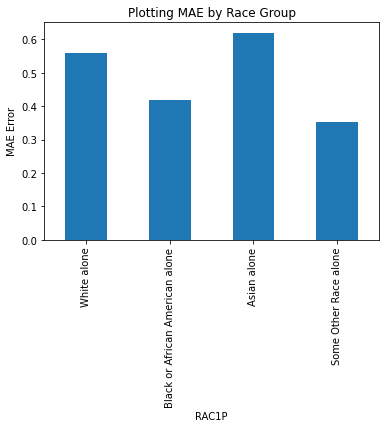

In [7]:
# metric frame report for race
race_mf = MetricFrame(metrics=mean_absolute_error,
                        y_true=y_test,
                        y_pred=yhat,
                        sensitive_features=pd.Series(X_test[sf[0]], name=sf[0]))

race_mf = race_mf.by_group.rename(index=race_map)
race_mf.plot(kind="bar", title = "Plotting MAE by Race Group", ylabel="MAE Error")

# fairML regression: GridSearch

This technique of mitigating the regressor with Bounded Group Loss and Grid Search will be applied to the modeling task within HMIS.

In [8]:
# use Exponentiated Gradient with BoundedGroupLoss constraint - a simple linear regressor
regressor = LinearRegression()
mitigator = GridSearch(regressor, constraints=BoundedGroupLoss(AbsoluteLoss(0, 1), upper_bound=.1))
mitigator.fit(X_train, y_train, sensitive_features=X_train[sf[0]])
y_pred_mitigated = mitigator.predict(X_test)

fairML_MAE = mean_absolute_error(y_test, y_pred_mitigated)
print("fairML MAE is:", fairML_MAE)

fairML MAE is: 0.5125712546231765


<AxesSubplot:title={'center':'Plotting MAE by Race Group - fairML'}, xlabel='RAC1P', ylabel='MAE Error'>

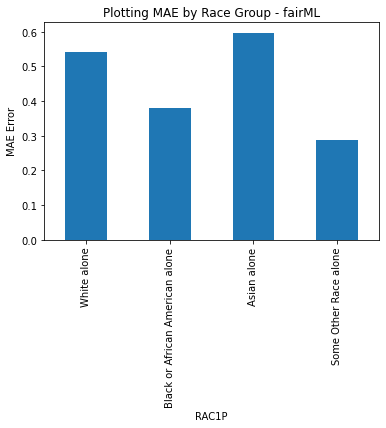

In [9]:
# assess the fairML MAE across race
mae_frame_fairML = MetricFrame(metrics=mean_absolute_error,
                        y_true=y_test,
                        y_pred=y_pred_mitigated,
                        sensitive_features=pd.Series(X_test[sf[0]], name=sf[0]))

race_mf_fairML = mae_frame_fairML.by_group.rename(index=race_map)
race_mf_fairML.plot(kind="bar", title = "Plotting MAE by Race Group - fairML", ylabel="MAE Error")